In [1]:
from __future__ import print_function, division

import torch
from PIL import Image
from torch.utils.data import random_split
from torchvision import transforms, utils, models
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from sklearn.model_selection import StratifiedKFold

import time
import copy

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root_dir = '/content/gdrive/MyDrive/shenzhen_tubeculosis/images/images'
csv_path = '/content/gdrive/MyDrive/shenzhen_tubeculosis/shenzhen_metadata.csv'

In [5]:
df = pd.read_csv(csv_path)

In [6]:
df.head(5)

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [7]:
class TubeDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.to_list()

        img_name = self.csv_file['study_id'][idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.fromarray(io.imread(img_path, as_gray=True))
        label = int(img_name[12])  # CHNCXR_0659_1.png
        sample = {'image': image, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    def add_transform(self, t):
        self.transform = t

0 (3000, 2919)
1 (3000, 2951)
2 (2987, 2945)
3 (3000, 2933)


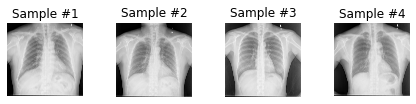

In [8]:
tube_dataset = TubeDataset(csv_file=df, root_dir=root_dir)
fig = plt.figure()

n_show = 4
for i in range(n_show):
    sample = tube_dataset[i]
    
    print(i, sample['image'].size)
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i+1))
    ax.axis('off')
    plt.imshow(sample['image'], cmap='gray')

plt.show()

## **Start Training**

In [94]:
batch_size = 4
num_epochs = 10
shuffle_dataset = True
validation_size = .2
num_workers = 4

In [74]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.458], [0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.458], [0.225])
    ]),
}

In [75]:
tube_dataset = TubeDataset(csv_file=df, root_dir=root_dir, transform=None)

In [104]:
dataset_size = len(tube_dataset)
indices = list(range(dataset_size))
n_valid = int(np.floor(validation_size * dataset_size))
n_train = dataset_size - n_valid

train_datasets, val_datasets = random_split(tube_dataset, [n_train, n_valid])
train_datasets.dataset.transform = data_transforms['train']
val_datasets.dataset.transform = data_transforms['val']

In [96]:
normal = 0
tube = 0
for sample in train_datasets:
    if sample['label'] == 0:
        normal += 1
    else:
        tube += 1

print("Train Datasets -> Normal: {} Tube: {}".format(normal, tube))

Train Datasets -> Normal: 267 Tube: 263


In [97]:
normal = 0
tube = 0
for sample in val_datasets:
    if sample['label'] == 0:
        normal += 1
    else:
        tube += 1

print("Valid Datasets -> Normal: {} Tube: {}".format(normal, tube))

Valid Datasets -> Normal: 59 Tube: 73


In [105]:
dataloaders = {'train': DataLoader(train_datasets, batch_size=batch_size, shuffle=shuffle_dataset, num_workers=num_workers),
               'val': DataLoader(val_datasets, batch_size=4, shuffle=True, num_workers=num_workers)}
dataset_sizes = {'train': n_train, 'val': n_valid}
class_names = {0: 'normal', 1: 'tubeculosis'}

In [99]:
print(len(dataloaders['val']))

33


In [83]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for batch in dataloaders[phase]:
                inputs = batch['image']
                labels = batch['label']
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train': 
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model


In [84]:
model_ft = models.resnet101(pretrained=True)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [85]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [106]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.1734 Acc: 0.9358
val Loss: 0.0785 Acc: 0.9848

Training complete in 1m 27s
Best val Acc: 0.984848


In [102]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 25))

    with torch.no_grad():
        for i, batch in enumerate(dataloaders['val']):
            inputs = batch['image']
            labels = batch['label']
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                prediction = preds.cpu().numpy()[j]
                actual = labels[j]
                correct = 'O' if prediction == actual else 'X'
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}({})'.format(class_names[preds.cpu().numpy()[j]], correct))
                image = torch.reshape(inputs.cpu().data[j], (224, 224))
                plt.imshow(image, cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

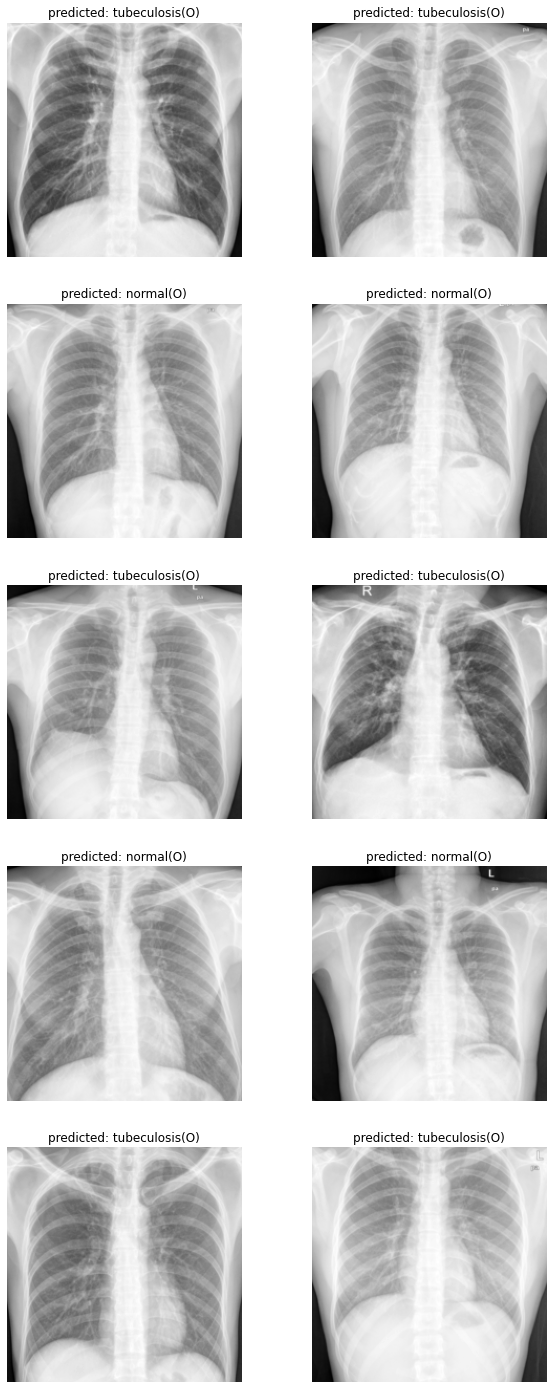

In [107]:
visualize_model(model_ft)

In [111]:
torch.save(model_ft.state_dict(), '/content/gdrive/MyDrive/shenzhen_tubeculosis/model.pth')

In [112]:
torch.save({'model': model_ft.state_dict(),
            'optimizer': optimizer_ft.state_dict(),
            'lr_scheduler': exp_lr_scheduler.state_dict()}, '/content/gdrive/MyDrive/shenzhen_tubeculosis/advanced_model.pth')